### **Jupyter Notebook for Prince of Songkla University Staff  Proof of Concept (POC) Test**
### Position: Data Scientist
#### Candidate ID: **PSU-057870 Mr. Trirat Aromrit**
------------------------------------------------------------------------------------------------

**Step01 : Install and Import Package or Library that using in JupyterNotebook**

In [29]:
#!pip install pycaret
#!pip install economic_complexity

In [116]:
import re
import os
import requests
import time
from   time import sleep
import json
from   datetime import datetime
import pandas as pd
import numpy  as np
from   tqdm import tqdm
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import itertools
import networkx as nx
import plotly.graph_objects as go
import ast
import economic_complexity as ec
from   pycaret.classification import ClassificationExperiment
from   pycaret.classification import *
from   sklearn.feature_extraction.text import TfidfVectorizer

## **Part 1: Comparative Research Landscape Analysis**

**Objective:**  
To understand and present an overview of the research competitiveness of leading universities in Thailand.

## Methodology I: Data Acquisition

1. **Identification of Target Institutions**  
   - Define the scope of analysis to include:
       * Asean Country
       * Thailand
       * 17 universities categorized under Group 1: Global and Frontier Research
       
   - Institutional list is referenced from the official *Reinventing University* website.  

2. **Data Source Selection**  
   - Primary database: **OpenAlex**, a third-party open scholarly database developed in collaboration with **arXiv (Cornell University)**.  
   - OpenAlex contains approximately **3 million publications**, closely aligned with arXiv’s total of **2,850,690 articles**.  

3. **Data Retrieval via API**  
   - Query publications from **arXiv** using country ID and institutional IDs of the 17 universities.  
   - Data extraction performed through the **arXiv API**, with the `source` parameter set to **arXiv (Cornell University)**.  
   - Note: The `arxiv-metadata-oai-snapshot.json` file does not include explicit author affiliation metadata, requiring reliance on institutional IDs for accurate filtering.  

4. **Data Consolidation**  
   - Aggregate the retrieved publications across all selected institutions.
   - The resulting dataset includes:
     * ASEAN Country: 7,418 publications
     * Thailand : 422 publications
     * Group 1 (Global and Frontier Research): 281 publications

```mermaid
graph LR
A((ASEAN: 7,418))
A --> B((THAI: 422))
B --> C((G1: 281))

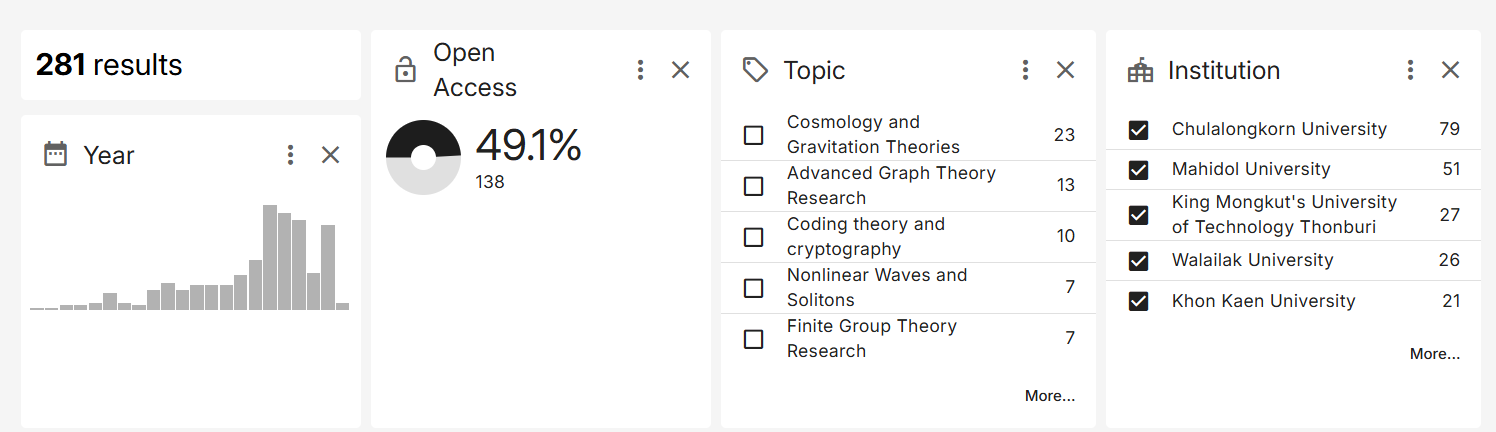
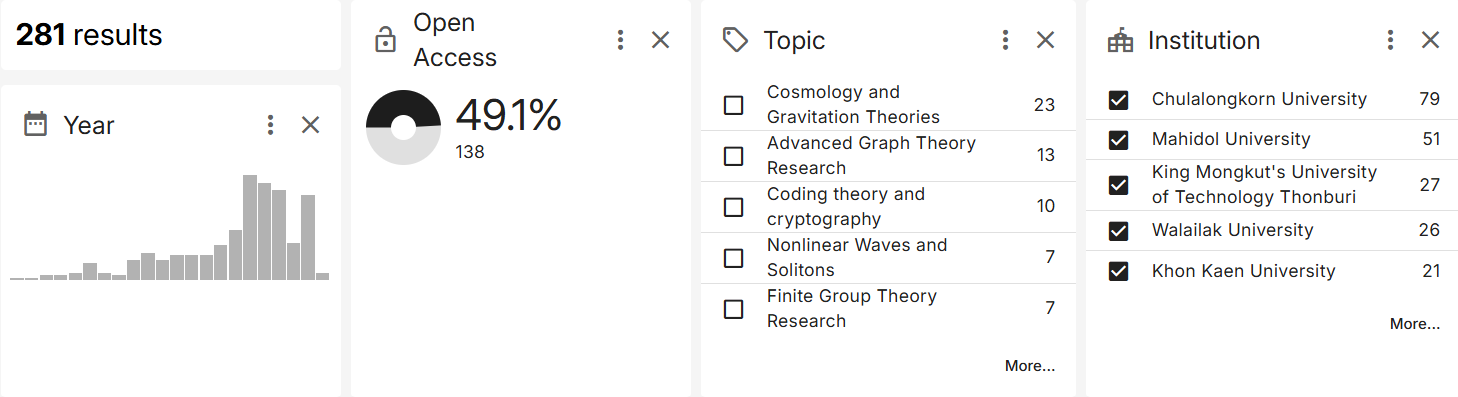

In [120]:
# Define directory path to arxiv-metadata-oai-snapshot.json
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
METADATA_PATH = str(os.path.join(dirname, filename))
METADATA_PATH = "/kaggle/input/arxiv/arxiv-metadata-oai-snapshot.json"

/kaggle/input/arxiv/arxiv-metadata-oai-snapshot.json
/kaggle/input/df-arxiv-author-index-asean/df_arxiv_author_index_asean.xlsx
/kaggle/input/dataset-arxiv-complete/dataset_arxiv_complete.xlsx
/kaggle/input/dataset-arxiv-author-complete/dataset_arxiv_author_complete.xlsx


In [121]:
def extract_work_id(work):
    doi = work.get('doi')
    if doi:
        match = re.search(r'arxiv\.(\d+\.\d+)', doi)
        if match:
            return match.group(1)
    oa_url = work.get('open_access', {}).get('oa_url')
    if oa_url:
        match = re.search(r'arxiv\.org/abs/(\d+\.\d+)', oa_url)
        if match:
            return match.group(1)
    
    primary = work.get('primary_location', {})
    landing_page = primary.get('landing_page_url')
    pdf_url = primary.get('pdf_url')
    for url in [landing_page, pdf_url]:
        if isinstance(url, str):
            match = re.search(r'arxiv\.org/(?:abs|pdf)/(\d+\.\d+)', url)
            if match:
                return match.group(1)
    
    patterns_old = [r'arxiv\.org/abs/([a-z\-]+/\d+)',r'arxiv\.org/pdf/([a-z\-]+/\d+)\.pdf']
    for field in [doi, oa_url, landing_page]:
        if isinstance(field, str):
            for pat in patterns_old:
                match = re.search(pat, field)
                if match:
                    return match.group(1)
    return None

In [122]:
def process_authorships(authors_json):
    countries = []
    institutions = []
    institution_types = []
    ror_ids = []
    authors = []

    for a in authors_json:
        authors.append(a.get('author', {}).get('display_name'))
        countries.extend(a.get('countries', []))
        for inst in a.get('institutions', []):
            institutions.append(inst.get('display_name'))
            institution_types.append(inst.get('type'))
            ror_ids.append(inst.get('ror'))

    countries_distinct_count = len(set(countries))
    institutions_distinct_count = len(set(institutions))

    return {
        "authors": authors,
        "countries": countries,
        "institutions": institutions,
        "institution_types": institution_types,
        "ror_ids": ror_ids,
        "countries_distinct_count": countries_distinct_count,
        "institutions_distinct_count": institutions_distinct_count
    }

In [123]:
def get_collaboration_type(authorship_info):
    types_set = set(authorship_info['institution_types'])

    has_academic = "funder" in types_set or "education" in types_set
    has_company = "company" in types_set
    has_government = "government" in types_set
    has_medical = "healthcare" in types_set
    has_other = any(t not in ["funder","company","government","healthcare","education"] for t in types_set)

    collaboration_types = []
    if has_academic and has_company:
        collaboration_types.append("Academic-corporate")
    if has_academic and has_government:
        collaboration_types.append("Academic-government")
    if has_academic and has_medical:
        collaboration_types.append("Academic-medical")
    if has_academic and has_other:
        collaboration_types.append("Academic-other")
    if has_academic and not (has_company or has_government or has_medical or has_other):
        collaboration_types.append("Academic only")
    if not has_academic:
        collaboration_types.append("Other")

    return collaboration_types

In [124]:
def get_collaboration_scope(authorship_info):
    countries = set(authorship_info['countries'])
    institutions = set(authorship_info['institutions'])
    authors_count = len(authorship_info['authors'])

    if authors_count == 1:
        return "Single authorship (no collaboration)"
    if len(countries) == 1 and len(institutions) > 1:
        return "Only national collaboration"
    if len(countries) == 1 and len(institutions) == 1:
        return "Only institutional collaboration"
    if len(countries) > 1:
        return "International collaboration"

In [125]:
def get_university_group_1_list(authorship_info):
    UNIVERSITY_GROUP_1_ROR = [
    "https://ror.org/0575ycz84",
    "https://ror.org/028wp3y58",
    "https://ror.org/03cq4gr50",
    "https://ror.org/05gzceg21",
    "https://ror.org/05m2fqn25",
    "https://ror.org/0057ax056",
    "https://ror.org/05sgb8g78",
    "https://ror.org/002yp7f20",
    "https://ror.org/03e2qe334",
    "https://ror.org/0453j3c58",
    "https://ror.org/01znkr924",
    "https://ror.org/00mwhaw71",
    "https://ror.org/04b69g067",
    "https://ror.org/02d0tyt78",
    "https://ror.org/010g30191",
    "https://ror.org/048e91n87",
    "https://ror.org/053jehz60"
    ]
    
    universities_group_1 = [
        inst_name
        for inst_name, ror in zip(authorship_info.get('institutions', []), authorship_info.get('ror_ids', []))
        if ror in UNIVERSITY_GROUP_1_ROR
    ]
    return {
        "University_group_1": universities_group_1,
        "University_group_status": bool(universities_group_1),
        "University_group_1_count": len(set(universities_group_1))
    }

In [126]:
def summarize_citations(counts_by_year, publication_year, latest_year=None):
    """
    Calculate citation summaries:
    - first_year_citation: citations in publication year (0 if missing)
    - recent_year_citation: citations in the latest year (0 if missing)
    - three_years_citation: total from last 3 years
    - five_years_citation: total from last 5 years
    """
    if not isinstance(counts_by_year, list):
        return {"first_year_citation": 0, "recent_year_citation": 0,
                "three_years_citation": 0, "five_years_citation": 0}
    
    # Convert to dict
    year_dict = {item.get('year'): item.get('cited_by_count', 0) for item in counts_by_year if 'year' in item}

    # Auto-detect latest year if not provided
    if latest_year is None:
        latest_year = max(year_dict.keys()) if year_dict else publication_year

    # First year citation
    first_year_citation = year_dict.get(publication_year, 0)

    # Recent year citation
    recent_year_citation = year_dict.get(latest_year, 0)

    # Three-year and five-year totals
    three_years = [latest_year - i for i in range(3)]
    five_years = [latest_year - i for i in range(5)]

    three_years_citation = sum(year_dict.get(y, 0) for y in three_years)
    five_years_citation = sum(year_dict.get(y, 0) for y in five_years)

    return {
        "first_year_citation": first_year_citation,
        "recent_year_citation": recent_year_citation,
        "three_years_citation": three_years_citation,
        "five_years_citation": five_years_citation,
        "total_publish_years" : 2024-int(publication_year)
    }

In [127]:
import json
from tqdm import tqdm

def build_arxiv_index(METADATA_PATH):
    """
    Build a dictionary index: work_id -> metadata
    Index all work_ids in the metadata file.
    """
    index = {}
    with open(METADATA_PATH, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="Indexing arXiv metadata"):
            row = json.loads(line)
            work_id = row.get("id")
            if not work_id:
                continue

            # Combine authors for easy explode
            authors_combined = [
                " ".join([part for part in [author[1], author[2], author[0]] if part]).strip()
                for author in row.get("authors_parsed", []) if author
            ]

            # Split categories for easy explode
            categories_combined = row.get("categories", "").split() if "categories" in row else []

            # Save to index
            index[work_id] = {
                "submitter": row.get("submitter", ""),
                "authors": row.get("authors", ""),
                "title": row.get("title", ""),
                "comments": row.get("comments", ""),
                "journal_ref": row.get("journal-ref", ""),
                "doi": row.get("doi", ""),
                "report_no": row.get("report-no", ""),
                "categories": categories_combined,
                "license": row.get("license", ""),
                "abstract": row.get("abstract", ""),
                "authors_parsed": authors_combined
            }
    return index

def extract_data_arxiv(work_id, arxiv_index):
    return arxiv_index.get(work_id, {
        "submitter": "",
        "authors": "",
        "title": "",
        "comments": "",
        "journal_ref": "",
        "doi": "",
        "report_no": "",
        "categories": [],
        "license": "",
        "abstract": "",
        "authors_parsed": []
    })

In [128]:
def fetch_author_info(author_url):
    # แนะนำให้แน่ใจว่า URL เริ่มต้นด้วย api.openalex.org
    if not author_url.startswith("https://api.openalex.org/authors/"):
        author_url = author_url.replace("https://openalex.org/", "https://api.openalex.org/authors/")
        
    try:
        response = requests.get(author_url)
        if response.status_code == 200:
            data = response.json()
            summary_stats = data.get('summary_stats', {})
            return {
                'works_count': data.get('works_count', 0),
                'cited_by_count': data.get('cited_by_count', 0),
                'mean_2yr_citedness': summary_stats.get('2yr_mean_citedness', 0),
                'h_index': summary_stats.get('h_index', 0),
                'i10_index': summary_stats.get('i10_index', 0)
            }
        else:
            print(f"Error: status code {response.status_code} for {author_url}")
            return None
    except Exception as e:
        print(f"Error fetching {author_url}: {e}")
        return None

In [129]:
def create_arxiv_from_openalex(openalex_json,arxiv_index):
    updated_rows = []
    results = openalex_json.get("results", [])
    for work in tqdm(results, desc="Processing OpenAlex works"):
        work_id = extract_work_id(work)

        citation_percentile = work.get('citation_normalized_percentile') or {}
        primary_topic = work.get('primary_topic') or {}
        open_access = work.get('open_access') or {}

        topics_list = [t['display_name'] for t in work.get('topics', []) if t.get('score', 0) > 0.6]
        sustainability = [f"SDG{t['id'].split('/')[-1]} : {t['display_name']}" 
                          for t in work.get('sustainable_development_goals', [])]

        authorship_info  = process_authorships(work.get('authorships', []))
        collab_type      = get_collaboration_type(authorship_info)
        collab_scope     = get_collaboration_scope(authorship_info)
        uni_group_cols   = get_university_group_1_list(authorship_info)

        publication_year = work.get('publication_year')
        counts_by_year   = work.get('counts_by_year', [])
        latest_year      = 2024
        citation_summary = summarize_citations(counts_by_year, publication_year, latest_year)
        arxiv_data       = extract_data_arxiv(work_id, arxiv_index)

        updated = {
            'work_id': work_id,
            'openalex_id': work.get('id'),
            'title': work.get('title'),
            'publication_year': publication_year,
            'publication_date': work.get('publication_date'),
            'doi': work.get('doi'),
            'fwci': work.get('fwci') or 0,
            'cited_by_count': work.get('cited_by_count') or 0,
            'citation_normalized_percentile': citation_percentile.get('value', 0),
            'is_in_top_1_percent': citation_percentile.get('is_in_top_1_percent'),
            'is_in_top_10_percent': citation_percentile.get('is_in_top_10_percent'),
            'primary_topic': primary_topic.get('display_name'),
            'subfield': primary_topic.get('subfield', {}).get('display_name'),
            'field': primary_topic.get('field', {}).get('display_name'),
            'domain': primary_topic.get('domain', {}).get('display_name'),
            'topics_list': topics_list,
            'Sustainability': sustainability,
            'related_works_count': len(work.get('related_works', [])),
            'referenced_works_count': work.get('referenced_works_count'),
            'is_open_access': open_access.get('is_oa'),
            'open_access_status': open_access.get('oa_status'),
            'countries': authorship_info['countries'],
            'institutions': authorship_info['institutions'],
            'institution_types': authorship_info['institution_types'],
            'countries_distinct_count': authorship_info['countries_distinct_count'],
            'institutions_distinct_count': authorship_info['institutions_distinct_count'],
            'Collaboration type': collab_type,
            'Collaboration_scope': collab_scope,
            **uni_group_cols,
            **citation_summary,
            **arxiv_data
        }

        updated_rows.append(updated)

    df_arxiv_new = pd.DataFrame(updated_rows)
    return df_arxiv_new


In [130]:
def create_arxiv_author_level_from_openalex(openalex_json, arxiv_index):
    """
    openalex_json : OpenAlex works JSON
    arxiv_index : path or dict for arxiv metadata
    df_author_index : DataFrame with columns ['author_id', 'works_count', 'cited_by_count', 'mean_2yr_citedness', 'h_index', 'i10_index']
    """
    rows = []
    # Convert df_author_index to dict for fast lookup
    df_author_index = pd.read_excel("/kaggle/input/df-arxiv-author-index-asean/df_arxiv_author_index_asean.xlsx")
    author_index_cache = df_author_index.set_index('author_id').to_dict('index')

    UNIVERSITY_GROUP_1_ROR = [
        "https://ror.org/0575ycz84",
        "https://ror.org/028wp3y58",
        "https://ror.org/03cq4gr50",
        "https://ror.org/05gzceg21",
        "https://ror.org/05m2fqn25",
        "https://ror.org/0057ax056",
        "https://ror.org/05sgb8g78",
        "https://ror.org/002yp7f20",
        "https://ror.org/03e2qe334",
        "https://ror.org/0453j3c58",
        "https://ror.org/01znkr924",
        "https://ror.org/00mwhaw71",
        "https://ror.org/04b69g067",
        "https://ror.org/02d0tyt78",
        "https://ror.org/010g30191",
        "https://ror.org/048e91n87",
        "https://ror.org/053jehz60"
    ]

    for work in tqdm(openalex_json.get("results", []), desc="Processing works"):
        work_id = extract_work_id(work)
        citation_percentile = work.get('citation_normalized_percentile') or {}
        primary_topic = work.get('primary_topic') or {}
        open_access = work.get('open_access') or {}

        topics_list = [t.get('display_name') for t in work.get('topics', []) if t.get('score', 0) > 0.6] or None
        sustainability = [f"SDG{t.get('id', '').split('/')[-1]} : {t.get('display_name')}" 
                          for t in work.get('sustainable_development_goals', [])] or None

        authorship_info = process_authorships(work.get('authorships', []))
        collab_type = get_collaboration_type(authorship_info) or None
        collab_scope = get_collaboration_scope(authorship_info) or None
        publication_year = work.get('publication_year')
        counts_by_year = work.get('counts_by_year', [])
        latest_year = 2024
        citation_summary = summarize_citations(counts_by_year, publication_year, latest_year)
        arxiv_data = extract_data_arxiv(work_id, arxiv_index)

        for a in work.get('authorships', []):
            author = a.get('author', {})
            author_id = author.get('id')
            institutions = a.get('institutions', [{}])

            has_ror_in_group = any(inst.get('ror') in UNIVERSITY_GROUP_1_ROR for inst in institutions if inst.get('ror'))

            # ✅ Get author metrics from DataFrame cache or zeros if not found
            if has_ror_in_group and author_id in author_index_cache:
                author_metrics = author_index_cache[author_id]
            else:
                author_metrics = {
                    'works_count': 0,
                    'cited_by_count': 0,
                    'mean_2yr_citedness': 0,
                    'h_index': 0,
                    'i10_index': 0
                }

            for inst in institutions or [{}]:
                row = {
                    'work_id': work_id,
                    'openalex_id': work.get('id'),
                    'title': work.get('title'),
                    'publication_year': publication_year,
                    'publication_date': work.get('publication_date'),
                    'doi': work.get('doi'),
                    'fwci': work.get('fwci') or 0,
                    'cited_by_count': work.get('cited_by_count') or 0,
                    'citation_normalized_percentile': citation_percentile.get('value', 0),
                    'is_in_top_1_percent': citation_percentile.get('is_in_top_1_percent') or 0,
                    'is_in_top_10_percent': citation_percentile.get('is_in_top_10_percent') or 0,
                    'primary_topic': primary_topic.get('display_name'),
                    'subfield': primary_topic.get('subfield', {}).get('display_name'),
                    'field': primary_topic.get('field', {}).get('display_name'),
                    'domain': primary_topic.get('domain', {}).get('display_name'),
                    'topics_list': topics_list,
                    'Sustainability': sustainability,
                    'related_works_count': len(work.get('related_works', [])) or 0,
                    'referenced_works_count': work.get('referenced_works_count') or 0,
                    'is_open_access': open_access.get('is_oa'),
                    'open_access_status': open_access.get('oa_status'),
                    'Collaboration type': collab_type,
                    'Collaboration_scope': collab_scope,
                    **citation_summary,
                    **arxiv_data,
                    # --- Author info ---
                    'author_id': author_id,
                    'author_name': author.get('display_name'),
                    'author_countries': a.get('countries'),
                    'author_institution': inst.get('display_name'),
                    'author_institution_type': inst.get('type'),
                    'author_ror_id': inst.get('ror'),
                    'is_in_university_group_1': inst.get('ror') in UNIVERSITY_GROUP_1_ROR if inst.get('ror') else False,
                    # --- Author metrics from DataFrame ---
                    'author_works_count': author_metrics['works_count'],
                    'author_cited_by_count': author_metrics['cited_by_count'],
                    'author_mean_2yr_citedness': author_metrics['mean_2yr_citedness'],
                    'author_h_index': author_metrics['h_index'],
                    'author_i10_index': author_metrics['i10_index']
                }
                rows.append(row)

    df_author_level = pd.DataFrame(rows)
    return df_author_level


In [ ]:
base_url = "https://api.openalex.org/works"
per_page = 200  # สูงสุดที่ OpenAlex อนุญาตคือ 200
page = 1
all_results = []

while True:
    url = f"{base_url}?page={page}&per_page={per_page}&filter=primary_location.source.id:s4306400194,authorships.countries:countries/th|countries/sg|countries/my|countries/id|countries/vn|countries/la|countries/kh|countries/ph|countries/mm|countries/bn&sort=cited_by_count:desc"
    response = requests.get(url)
    data = response.json()
    
    results = data.get("results", [])
    if not results:
        break  # ไม่มีข้อมูลแล้ว ให้หยุด loop
    
    all_results.extend(results)
    print(page)
    page += 1
    time.sleep(5)  # ป้องกัน rate-limit

openalex_json_all = {"results": all_results}
METADATA_PATH     = "/kaggle/input/arxiv/arxiv-metadata-oai-snapshot.json"
arxiv_index       = build_arxiv_index(METADATA_PATH)

In [133]:
df_arxiv_new      = create_arxiv_from_openalex(openalex_json_all,arxiv_index)
df_arxiv_author   = create_arxiv_author_level_from_openalex(openalex_json_all,arxiv_index)

Processing works: 100%|██████████| 7418/7418 [00:00<00:00, 17862.97it/s]


In [17]:
df_arxiv_new.to_excel("/kaggle/working/dataset_arxiv_complete.xlsx", index=False)

## Methodology II : Comparative Exploratory Data Analysis (EDA)

1. **Publication Volume Analysis**  
   - Compare the number of publications per year for each university.  

2. **Research Category Analysis**  
   - Identify key focus areas by analyzing and visualizing research categories emphasized by each university.  

3. **Co-authorship Network Analysis**  
   - Perform preliminary analysis of co-authorship networks to explore collaboration patterns within and across institutions.  

4. **Data Visualization**  
   - Present the results using clear and informative visualizations to compare publication volume, research categories, and collaboration networks.

### **01 Publication Volume Analysis**
1. Filters the dataset to include only authors from the universities in group_1
2. Counting works per institution per year
3. Mapping full names to short names
4. Filtering specific universities and years
5. Color mapping
6. Grouped Bar Chart
7. Faceted Bar Chart (2 columns)


In [134]:
#Filters the dataset to include only authors from the universities in group_1
df_filtered = df_arxiv_author[df_arxiv_author['is_in_university_group_1'] == True]

In [135]:
#Counting works per institution per year
df_count = (df_filtered.groupby(['author_institution', 'publication_year'])
            .agg({'work_id':'nunique'})
            .reset_index().rename(columns={'work_id':'count_work'}))

In [136]:
# University Name Mapping
name_map = {
    "Prince of Songkla University": "PSU",
    "Chulalongkorn University": "CU",
    "Khon Kaen University": "KKU",
    "Kasetsart University": "KU",
    "Chiang Mai University": "CMU",
    "King Mongkut's University of Technology Thonburi": "KMUTT",
    "Suranaree University of Technology": "SUT",
    "Thammasat University": "TU",
    "Naresuan University": "NU",
    "Mahasarakham University": "MSU",
    "Mahidol University": "MU",
    "Mae Fah Luang University": "MFU",
    "Walailak University": "WU",
    "Silpakorn University": "SU",
    "National Institute of Development Administration": "NIDA",
    "Chulabhorn Graduate Institute": "CGI",
    "Vidyasirimedhi Institute of Science and Technology": "VIST"
}

df_count['institution_short'] = df_count['author_institution'].map(name_map)

In [137]:
# Filter only target university 5 University and publish years between 2014-2024
target_uni = ["CMU", "CU", "KMUTT", "MU", "PSU"]
df_count = df_count[df_count['institution_short'].isin(target_uni)]
df_count = df_count[(df_count['publication_year'] >= 2014) & (df_count['publication_year'] <= 2024)]

In [138]:
color_map = {
    "CU": "#DE5C8E",
    "CMU": "#6868AC",
    "KMUTT": "#FF4602",
    "MU": "#253988",
    "PSU": "#003C71"
}

In [139]:
fig_grouped = px.bar(
    df_count,
    x='publication_year',
    y='count_work',
    color='institution_short',
    barmode='group',
    text='count_work',
    title="Grouped Bar: Research Works by Selected Universities (2014-2024)",
    labels={'publication_year':'Year', 'count_work':'Number of Pubs', 'institution_short':'Institution'},
    color_discrete_map=color_map
)
fig_grouped.update_traces(textposition='auto')
fig_grouped.update_layout(
    title=dict(
        text=(
            "<b>Research Publications Trend Analysis</b><br>"
            "Number of research works published per year (2014-2024)"
            " by Global and Frontier Research Universities<br>"
        ),
        x=0,
        xanchor='left'
    ),
    margin=dict(l=80, r=40, t=120, b=40),
    xaxis=dict(type='linear', dtick=1, range=[2014, 2024]),
    plot_bgcolor='white'
)
fig_grouped.show()

In [127]:
# Plot Faceted Bar Chart (2 columns)

fig_facet = px.bar(
    df_count,
    x='publication_year',
    y='count_work',
    text='count_work',
    color='institution_short',
    facet_col='institution_short',
    facet_col_wrap=2,
    title="Faceted Bar: Research Works by Selected Universities (2014-2024)",
    labels={'publication_year':'Year', 'count_work':'Number of Pubs'},
    color_discrete_map=color_map
    
)
fig_facet.update_traces(textposition='auto')
fig_facet.update_layout(
    title=dict(
        text=(
            "<b>Research Publications Trend Analysis</b><br>"
            "Annual number of research works published from 2014 to 2024<br>"
            "by each Global and Frontier Research Universities"
        ),
        x=0,
        xanchor='left'
    ),
    autosize=True,
    margin=dict(l=80, r=40, t=150, b=40),
    xaxis=dict(type='linear', dtick=1, range=[2014, 2024]),
    plot_bgcolor='white'
)
fig_facet.show()

### **02 Research Category Analysis**
1. Filters the dataset to include only authors from the universities in group_1
2. Counts the number of unique research works (work_id) per institution and field
3. Calculates the percentage share of each research field within each university
4. Maps full university names to short names for better visualization
5. Creates a horizontal stacked bar chart showing the proportion of research publications by field for each university
6. Displays percentage values (2 decimal places) inside each bar segment
7. Rotates the text inside the bars to be vertically aligned for readability

In [146]:
# 1️⃣ Filter authors from group 1 universities
df_filtered = df_arxiv_author[df_arxiv_author['is_in_university_group_1'] == True]

# 2️⃣ Count unique works per institution per field
df_field_count = (
    df_filtered.groupby(['author_institution', 'field'])
    .agg({'work_id':'nunique'})
    .reset_index()
    .rename(columns={'work_id':'count_work'})
)

# 3️⃣ Calculate the proportion (%) per university using transform
df_field_count['percent'] = df_field_count.groupby('author_institution')['count_work'] \
                                         .transform(lambda x: x / x.sum() * 100)
df_field_count['percent_label'] = df_field_count['percent'].map(lambda x: f"{x:.2f}")

# Map full names to short names
df_field_count['institution_short'] = df_field_count['author_institution'].map(name_map).fillna(df_field_count['author_institution'])

# Horizontal stacked bar chart
fig_stacked_h = px.bar(
    df_field_count,
    y='institution_short',    # use short names on y-axis
    x='percent',              # proportion
    color='field',            # fields stacked
    text=df_field_count['percent_label'], 
    labels={'institution_short':'University', 'percent':'% of Publications', 'field':'Field'},
    title="Research Field Distribution per University (Group 1)",
    orientation='h'
)

# Adjust layout
fig_stacked_h.update_traces(
    textposition='inside',
    textangle=360) # rotate numbers to be vertical
    
fig_stacked_h.update_layout(
    title=dict(
        text=(
            "<b>Research Category Analysis</b><br>"
            "Distribution of research publications by field (2014–2024)<br>"
            "across Global and Frontier Research Universities"),
        x=0,
        xanchor='left'
    ),
    barmode='stack',         
    xaxis=dict(title='% of Publications', range=[0,100]),
    yaxis=dict(title='University', tickangle=0),  # vertical short names
    autosize=True,
    margin=dict(l=120, r=40, t=120, b=80),
    plot_bgcolor='white'
)

fig_stacked_h.show()

### **03 Co-authorship Network Analysis**
1. Filter the dataset to include only authors from the universities in group_1
2. Map full institution names to short names for consistency
3. Explode multi-author or multi-collaboration fields into individual rows if needed
4. Create pairs of co-authors for each publication (edge list)
5. Aggregate edges to count the number of collaborations between institutions/authors
6. Build network graph using nodes (authors or institutions) and edges (collaborations)
7. Compute network metrics (degree centrality, betweenness, etc.) to explore collaboration patterns
8. Visualize co-authorship networks using network plots (e.g., networkx, pyvis, plotly)
9. Optionally, color nodes by institution or group and size nodes by collaboration frequency

In [46]:
df_arxiv_author = pd.read_excel("/kaggle/working/dataset_arxiv_author_complete.xlsx")
df_filtered = df_arxiv_author[df_arxiv_author['is_in_university_group_1'] == True].copy()
df_filtered['authors_parsed'] = df_filtered['authors_parsed'].apply(ast.literal_eval)
df_filtered['Collaboration type'] = df_filtered['Collaboration type'].apply(ast.literal_eval)
df_filtered = df_filtered.assign(
    Collaboration_type_list=df_filtered['Collaboration type']
).explode('Collaboration_type_list')

In [51]:
import plotly.graph_objects as go
import random

# --- Mapping ชื่อมหาวิทยาลัยเป็น short name ---
name_map = {
    "Prince of Songkla University": "PSU",
    "Chulalongkorn University": "CU",
    "Khon Kaen University": "KKU",
    "Kasetsart University": "KU",
    "Chiang Mai University": "CMU",
    "King Mongkut's University of Technology Thonburi": "KMUTT",
    "Suranaree University of Technology": "SUT",
    "Thammasat University": "TU",
    "Naresuan University": "NU",
    "Mahasarakham University": "MSU",
    "Mahidol University": "MU",
    "Mae Fah Luang University": "MFU",
    "Walailak University": "WU",
    "Silpakorn University": "SU",
    "National Institute of Development Administration": "NIDA",
    "Chulabhorn Graduate Institute": "CGI",
    "Vidyasirimedhi Institute of Science and Technology": "VIST"
}

df_filtered['institution_short'] = df_filtered['author_institution'].map(name_map)

# --- กรองเฉพาะ 5 มหาวิทยาลัย ---
target_uni = ["CMU", "CU", "KMUTT", "MU", "PSU"]
df_filtered = df_filtered[df_filtered['institution_short'].isin(target_uni)].copy()

# --- กำหนดสีสำหรับสถาบัน ---
color_map = {
    "CU": "#DE5C8E",
    "CMU": "#6868AC",
    "KMUTT": "#FF4602",
    "MU": "#253988",
    "PSU": "#003C71"
}

# --- สร้าง list ของ nodes ทั้งหมด ---
institutions = df_filtered['institution_short'].unique()
scopes = df_filtered['Collaboration_scope'].unique()
types = df_filtered['Collaboration_type_list'].unique()

all_nodes = list(institutions) + list(scopes) + list(types)
node_dict = {name: i for i, name in enumerate(all_nodes)}

# --- กำหนดสี node ---
node_colors = {}
for node in all_nodes:
    if node in color_map:
        node_colors[node] = color_map[node]
    else:
        # สี random สำหรับ Scope / Type
        node_colors[node] = f'rgba({random.randint(50,255)},{random.randint(50,255)},{random.randint(50,255)},0.8)'

# --- Link 1: Institution → Scope ---
link1 = df_filtered.groupby(['institution_short', 'Collaboration_scope']).size().reset_index(name='value')
link1_source = link1['institution_short'].map(node_dict)
link1_target = link1['Collaboration_scope'].map(node_dict)
link1_value = link1['value']
link1_color = [node_colors[src] for src in link1['institution_short']]

# --- Link 2: Scope → Type ---
link2 = df_filtered.groupby(['Collaboration_scope', 'Collaboration_type_list']).size().reset_index(name='value')
link2_source = link2['Collaboration_scope'].map(node_dict)
link2_target = link2['Collaboration_type_list'].map(node_dict)
link2_value = link2['value']
link2_color = [node_colors[src] for src in link2['Collaboration_scope']]

# --- รวม link ทั้งสองชุด ---
all_sources = list(link1_source) + list(link2_source)
all_targets = list(link1_target) + list(link2_target)
all_values = list(link1_value) + list(link2_value)
all_colors = list(link1_color) + list(link2_color)

# --- สร้าง Sankey diagram ---
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=15,
        line=dict(color="black", width=0.5),
        label=all_nodes,
        color=[node_colors[node] for node in all_nodes]
    ),
    link=dict(
        source=all_sources,
        target=all_targets,
        value=all_values,
        color=all_colors
    )
)])

fig.update_layout(
    title=dict(
        text=(
            "<b>Collaboration Network Analysis</b><br>"
            "3-step Collaboration Sankey Diagram"
            "across Global and Frontier Research Universities"),
        x=0,
        xanchor='left'
    ))
fig.show()

In [54]:
df_filtered = df_arxiv_author[df_arxiv_author['is_in_university_group_1'] == True].copy()
df_filtered['authors_parsed'] = df_filtered['authors_parsed'].apply(ast.literal_eval)
edges = []
for _, row in df_filtered.iterrows():
    authors = row['authors_parsed']
    work_id = row['work_id']
    # Create edges between all co-authors (pairwise)
    for i in range(len(authors)):
        for j in range(i + 1, len(authors)):
            edges.append((authors[i], authors[j], work_id))
# Convert to DataFrame
df_edges = pd.DataFrame(edges, columns=['source', 'target', 'work_id'])
# Compute weight: number of collaborations between each pair
df_edges['weight'] = df_edges.groupby(['source','target'])['work_id'].transform('count')

### **04 Economic Complexity Index (Research) Analysis**
# Economic Complexity Index (Research)

## Definition

>The **Economic Complexity Index (ECI)** in the research context measures the **capability and sophistication of a research institution** based on the diversity and complexity of topics it publishes. It is derived from the concept of economic complexity in international trade, adapted to research output.

Formally, ECI considers:
1. **Diversity:** The number of distinct research topics an institution is active in.
2. **Ubiquity:** How rare or specialized each topic is across all institutions.

Institutions that publish in many highly specialized topics achieve a **higher ECI**, reflecting advanced research capabilities.

---

## Interpretation

- **High ECI:**  
  - The institution engages in a **diverse set of specialized topics**.  
  - Capable of producing **advanced and impactful research** across multiple complex areas.  
  - *Example:* A university publishing in cutting-edge AI, quantum computing, and advanced materials research would have a high ECI.

- **Low ECI:**  
  - The institution focuses on **fewer or more ubiquitous topics**.  
  - Research may be **less specialized or less complex**.  
  - *Example:* A university publishing primarily in common, well-established areas would have a lower ECI.

---

## Summary Table

| Metric       | Meaning                                                                 |
|--------------|-------------------------------------------------------------------------|
| **ECI (High)** | Institution produces research in many complex and specialized topics; reflects advanced capability |
| **ECI (Low)**  | Institution publishes in fewer or common topics; less complex research portfolio |


In [17]:
df_arxiv_author = pd.read_excel("/kaggle/input/dataset-arxiv-author-complete/dataset_arxiv_author_complete.xlsx")

In [21]:
df_filtered = df_arxiv_author[df_arxiv_author['is_in_university_group_1'] == True].copy()
df_filtered = df_filtered[['work_id','author_institution', 'topics_list', 'publication_year']]
df_filtered['topics_list'] = df_filtered['topics_list'].fillna('[]')
df_filtered['topics_list'] = df_filtered['topics_list'].apply(ast.literal_eval)
df_filtered = df_filtered.explode('topics_list')

In [23]:
df_summary = (
    df_filtered
    .groupby(['author_institution', 'topics_list', 'publication_year'])
    .agg({'work_id':'nunique'})
    .reset_index())

In [60]:
tbl = (df_summary.pivot_table(index='author_institution',
                              columns='topics_list',
                              values='work_id',
                              fill_value=0)).reset_index().set_index('author_institution').dropna(axis=1, how='all')  # drop topics with all 0.astype(float))

rca = ec.rca(tbl)
eci_value, pci_value = ec.complexity(rca)
eci = eci_value.to_frame(name="ECI").reset_index().rename(columns={'author_institution':'Institution'})

print("University Group 1 Highest ECIs (Institution Complexity Index)")
display(eci.sort_values(by='ECI', ascending=False))


University Group 1 Highest ECIs (Institution Complexity Index)


,Institution,ECI
6,Mahidol University,0.745844
1,Chulalongkorn University,0.573940
0,Chiang Mai University,0.510819
10,Silpakorn University,0.490107
4,King Mongkut's University of Technology Thonburi,0.453606
11,Suranaree University of Technology,0.432759
14,Walailak University,0.430088
7,Naresuan University,0.346462
3,Khon Kaen University,0.330760
12,Thammasat University,0.254533


# Product Complexity Index (Research Topics) – Definition and Interpretation

## Definition
> The **Product Complexity Index (PCI)**, in the context of research, measures the **complexity of a research topic** based on how many and which institutions are capable of producing high-quality work in that topic. It is adapted from economic complexity theory applied to products in international trade.

Formally, PCI considers:
1. **Ubiquity:** How widespread a topic is across institutions. Rare topics are considered more complex.
2. **Institution diversity:** Complex topics are typically produced only by highly capable institutions with diverse research portfolios.

Topics that are tackled by few, highly capable institutions achieve a **higher PCI**, indicating higher research sophistication.

---

## Interpretation

- **High PCI:**  
  - Topic is **rare and specialized**.  
  - Only institutions with **advanced capabilities** can conduct research in this area.  
  - *Example:* Topics like “Quantum Photonics” or “Advanced Nanomaterials” may have high PCI.

- **Low PCI:**  
  - Topic is **common and widely studied**.  
  - Many institutions can publish in this area, indicating lower complexity.  
  - *Example:* Topics like “General Machine Learning” or “Basic Algebra” may have low PCI.

---

## Summary Table

| Metric       | Meaning                                                                 |
|--------------|-------------------------------------------------------------------------|
| **PCI (High)** | Topic is rare and specialized; only highly capable institutions can produce research |
| **PCI (Low)**  | Topic is common; many institutions can publish in this area, less complex |


In [61]:
pci = pci_value.to_frame(name="PCI").reset_index().rename(columns={'topics_list':'Topic'})
print("University Group 1 Highest PCIs (Product Complexity Index / Topic Complexity)")
display(pci.sort_values(by='PCI', ascending=False).head(10))

University Group 1 Highest PCIs (Product Complexity Index / Topic Complexity)


,Topic,PCI
288,Semiconductor materials and devices,0.721724
193,Mental Health via Writing,0.721724
196,Microbial Natural Products and Biosynthesis,0.721724
249,Photorefractive and Nonlinear Optics,0.721724
253,Plant biochemistry and biosynthesis,0.721724
308,Statistical Methods and Bayesian Inference,0.721724
273,Quasicrystal Structures and Properties,0.721724
277,Rare-earth and actinide compounds,0.721724
321,Text Readability and Simplification,0.721724
323,Textile materials and evaluations,0.721724


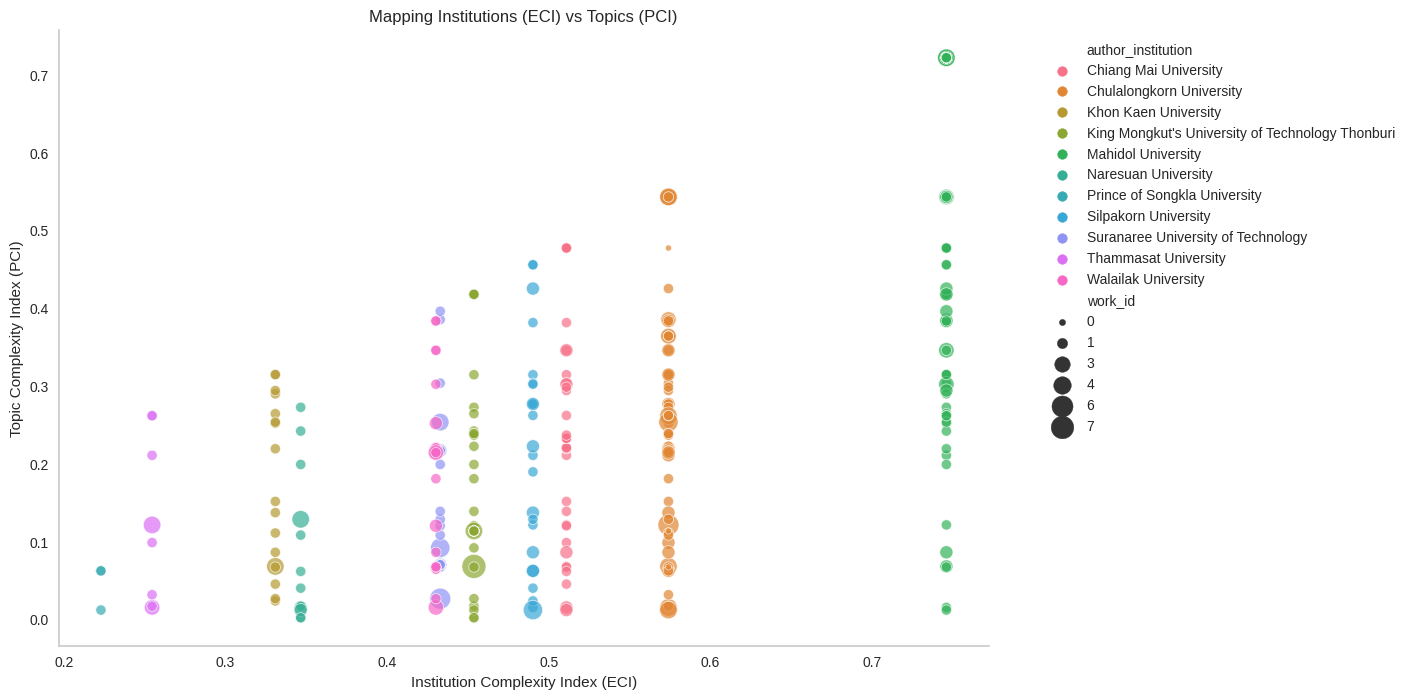

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

df_plot = (
    df_summary
    .groupby(['author_institution','topics_list'])
    .agg({'work_id':'sum'})
    .reset_index()
)

df_plot = df_plot.merge(eci, left_on='author_institution', right_on='Institution', how='left')
df_plot = df_plot.merge(pci, left_on='topics_list', right_on='Topic', how='left')
df_plot_filtered = df_plot[(df_plot['ECI'] > 0) & (df_plot['PCI'] > 0)].copy()
plt.figure(figsize=(12,8))
sns.scatterplot(
    data=df_plot_filtered,
    x='ECI',             # x-axis = Institution Complexity
    y='PCI',             # y-axis = Topic Complexity
    size='work_id',      # ขนาดจุด = จำนวน publication
    hue='author_institution', # สีแยกตาม Institution
    alpha=0.7,
    sizes=(20, 300)
)

plt.title('Mapping Institutions (ECI) vs Topics (PCI)')
plt.xlabel('Institution Complexity Index (ECI)')
plt.ylabel('Topic Complexity Index (PCI)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(False)
sns.despine()
plt.show()


# Relatedness – Definition and Interpretation

## Definition
> **Relatedness** measures the **proximity of a research topic to the existing capabilities of an institution**. It quantifies how easily an institution can expand into a new topic based on its current expertise.

Formally:
- Relatedness is derived from the **co-occurrence of topics** across institutions.
- A topic that frequently appears alongside topics an institution already specializes in will have a **high Relatedness** value.
- Values range from 0 to 1:
  - 0 → topic is unrelated to current capabilities
  - 1 → topic is highly related to existing expertise

---

## Interpretation

- **High Relatedness (close to 1):**  
  - The topic aligns well with the institution’s current research portfolio.  
  - Expansion into this topic is **easier and more feasible**.  
  - *Example:* If an institution publishes in “Machine Learning for Healthcare,” the relatedness to “AI in Cancer Detection” might be high.

- **Low Relatedness (close to 0):**  
  - The topic is far from the institution’s current expertise.  
  - Expansion into this topic is **difficult** and may require new capabilities or collaborations.  
  - *Example:* An institution focused on “Plant Biochemistry” has low relatedness to “Quantum Computing.”

---

## Summary Table

| Metric              | Meaning                                                                 |
|--------------------|-------------------------------------------------------------------------|
| **High Relatedness** | Topic aligns closely with institution’s existing capabilities; easier expansion |
| **Low Relatedness**  | Topic is unrelated to current expertise; difficult expansion |


In [54]:
rca = ec.rca(tbl)
phi = ec.proximity(rca)
relatedness = ec.relatedness(rca)
display(relatedness)

topics_list,3D Shape Modeling and Analysis,AI in cancer detection,Adaptive optics and wavefront sensing,Advanced Algebra and Geometry,Advanced Algebra and Logic,Advanced Banach Space Theory,Advanced Bandit Algorithms Research,Advanced Chemical Sensor Technologies,Advanced Clustering Algorithms Research,Advanced Combinatorial Mathematics,...,Video Surveillance and Tracking Methods,Visual Attention and Saliency Detection,Voice and Speech Disorders,Web Data Mining and Analysis,Wireless Networks and Protocols,advanced mathematical theories,demographic modeling and climate adaptation,graph theory and CDMA systems,nanoparticles nucleation surface interactions,semigroups and automata theory
author_institution,,,,,,,,,,,,,,,,,,,,,
Chiang Mai University,0.093858,0.045553,0.210929,0.372578,0.349829,0.371555,0.026940,0.019029,0.106443,0.262963,...,0.045553,0.000000,0.081172,0.068154,0.026940,0.210000,0.045553,0.342203,0.087515,0.511083
Chulalongkorn University,0.181661,1.000000,0.274143,0.319352,0.261911,0.320516,0.098781,0.207587,0.257813,0.578696,...,1.000000,0.152174,0.671967,0.194548,0.098781,0.317763,1.000000,0.246906,0.138669,0.303887
Kasetsart University,0.000000,0.023861,0.075562,0.025754,0.015794,0.024305,1.000000,0.059311,0.013675,0.031833,...,0.023861,0.000000,0.023431,0.007435,1.000000,0.040132,0.023861,0.062500,0.014527,0.063145
Khon Kaen University,0.028114,0.041215,0.734243,0.129507,0.086865,0.121088,0.079538,0.055480,0.089487,0.133952,...,0.041215,0.000000,0.058577,0.039653,0.079538,0.232763,0.041215,0.354579,0.117450,0.454384
King Mongkut's University of Technology Thonburi,0.037846,0.048807,0.194250,0.126711,0.105817,0.121219,0.021167,0.058446,0.365678,0.121409,...,0.048807,0.000000,0.081172,0.064436,0.021167,0.266711,0.048807,0.391708,1.000000,0.204960
Mahasarakham University,0.000000,0.004338,0.012901,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003326,...,0.004338,0.000000,0.003347,0.000000,0.000000,0.000000,0.004338,0.004332,0.000000,0.006907
Mahidol University,0.083261,0.170282,0.177387,0.638705,0.779152,0.698754,0.026940,0.000000,0.751741,0.508853,...,0.170282,0.152174,0.580753,1.000000,0.026940,0.207237,0.170282,0.199257,0.160239,0.262448
Naresuan University,0.091696,0.018438,0.164670,0.088300,0.033956,0.064277,0.021167,0.109107,0.075958,0.062114,...,0.018438,0.000000,0.025105,0.016109,0.021167,0.576316,0.018438,0.293936,0.143335,0.164310
National Institute of Development Administration,0.045415,0.000000,0.000000,0.005151,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.130435,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [59]:
df_psu = relatedness.loc['Prince of Songkla University']
df_psu_sorted = df_psu.sort_values(ascending=False)
df_psu_table = df_psu_sorted.reset_index()
df_psu_table.columns = ['Topic', 'Relatedness']
df_psu_table = df_psu_table[df_psu_table['Relatedness'] > 0.5]
print(df_psu_table)

                                                Topic  Relatedness
0                        Retinal Imaging and Analysis     1.000000
1                     Retinal Diseases and Treatments     1.000000
2      Service-Oriented Architecture and Web Services     1.000000
3                        Real-Time Systems Scheduling     1.000000
4              Security and Verification in Computing     1.000000
5               Advanced Chemical Sensor Technologies     1.000000
6   Physical Unclonable Functions (PUFs) and Hardw...     1.000000
7                  Advanced Data Storage Technologies     1.000000
8               Advanced Malware Detection Techniques     1.000000
9   Spectroscopy Techniques in Biomedical and Chem...     1.000000
10              Spectroscopy and Chemometric Analyses     1.000000
11            Distributed systems and fault tolerance     1.000000
12                        Green IT and Sustainability     1.000000
13             Advanced Numerical Analysis Techniques     0.66

## **Part 2: Prototype Development for Predictive Capability**

**Objective:**
To develop a tool capable of predicting the potential success of research projects in advance, using data extracted from Part 1.

### Target Variable Definition

**Target Variable:** `high_impact_paper` (High-Impact Paper)

## Definition

> A **high-impact paper** is defined as a paper that **belongs to the top 10% of comprehensive citations within the same field and publication year**.  
> *(Comprehensive citations combine the initial 1st-year citation, the most recent 3-year citations, and the average lifetime citation per year.)*

**Impact Score Equation:**

$$
\text{Impact Score}_{paper} = \text{1st-year citation} + \text{Recent 3-year citation} + \frac{\text{Total citations}}{\text{Publication Age (years)}}
$$

**High-Impact Condition:**

$$
\text{Impact Score}_{paper} \geq \text{Percentile}_{90} \big( \text{Impact Score} \big)_{field, year}
$$


## Rationale

1. **Comprehensive Citation Metric:**  
   - Combines **initial impact** (1st-year citations), **recent impact** (last 3-year citations), and **overall impact** (average lifetime citations) to reflect the paper’s true influence.  

2. **Field- and Year-Normalization:**  
   - Calculating the percentile **within the same field and publication year** reduces bias caused by differences in citation behavior across fields or publication years.  

3. **Top 10% Standard:**  
   - Using the **top 10%** threshold is a widely accepted method in bibliometrics to identify high-impact research papers.

### **2.1 Data Preparation**


In [89]:
dataset_arxiv = pd.read_excel("/kaggle/input/dataset-arxiv-complete/dataset_arxiv_complete.xlsx")

In [90]:
dataset_arxiv['total_publish_years'] = dataset_arxiv['total_publish_years'].apply(lambda x: 1 if x <= 0 else x)
dataset_arxiv['comprehensive_citation'] = (dataset_arxiv['first_year_citation'] + dataset_arxiv['three_years_citation'] + 
                                           (dataset_arxiv['cited_by_count'] / dataset_arxiv['total_publish_years']))
dataset_arxiv['comprehensive_citation'] = dataset_arxiv['comprehensive_citation'].fillna(0)
dataset_arxiv['field'] = dataset_arxiv['field'].fillna('Unknown')

In [91]:
dataset_arxiv['impact_threshold']  = dataset_arxiv.groupby(['field', 'publication_year'])['comprehensive_citation'].transform(lambda x: x.quantile(0.9))
dataset_arxiv['high_impact_paper'] = dataset_arxiv['comprehensive_citation'] >= dataset_arxiv['impact_threshold']

# **Building the Baseline Model** 
## Summary Feature

| Metric                | Meaning                                                                 |
|-----------------------|-------------------------------------------------------------------------|
| **Number of Authors** | Number of authors contributing to the paper                               |
| **Abstract Length**   | Length of the abstract of the paper                                       |
| **Field/Discipline**  | Research category or discipline of the paper                              |
| **Affiliated University** | University or institution to which the authors are affiliated         |


In [92]:
# สมมติ column University_group_status เป็น Boolean (True/False)
data_train = dataset_arxiv[dataset_arxiv['University_group_status'] == False].copy()
data_test  = dataset_arxiv[dataset_arxiv['University_group_status'] == True].copy()

# ตรวจสอบขนาด
print("Train size:", data_train.shape)
print("Test size :", data_test.shape)

Train size: (7137, 48)
Test size : (281, 48)


In [93]:
data_train['Number of Authors'] = data_train['authors_parsed'].apply(
    lambda x: len(ast.literal_eval(x)) if isinstance(x, str) else len(x) if isinstance(x, list) else 0)

data_train['Abstract Length']   = data_train['abstract'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
data_train['institutions']      = data_train['institutions'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
data_train = data_train.explode('institutions')

datamodel_train = data_train[['Number of Authors',
                           'Abstract Length',
                           'institutions',
                           'field','high_impact_paper']]
datamodel_train = datamodel_train.reset_index(drop=True)

In [94]:
data_test['Number of Authors'] = data_test['authors_parsed'].apply(
    lambda x: len(ast.literal_eval(x)) if isinstance(x, str) else len(x) if isinstance(x, list) else 0)

data_test['Abstract Length']   = data_test['abstract'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
data_test['institutions']      = data_test['institutions'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
data_test = data_test.explode('institutions')

datamodel_test = data_test[['Number of Authors',
                           'Abstract Length',
                           'institutions',
                           'field','high_impact_paper']]
datamodel_test = datamodel_test.reset_index(drop=True)

In [96]:
clf1 = ClassificationExperiment()
clf1 = setup(data = datamodel_train, target = 'high_impact_paper',categorical_features=['institutions','field'],
             session_id = 123)
lr = create_model('lr')

,Description,Value
0,Session id,123
1,Target,high_impact_paper
2,Target type,Binary
3,Original data shape,"(31569, 5)"
4,Transformed data shape,"(31569, 28)"
5,Transformed train set shape,"(22098, 28)"
6,Transformed test set shape,"(9471, 28)"
7,Numeric features,2
8,Categorical features,2
9,Rows with missing values,0.1%


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8290,0.7172,0.2165,0.6138,0.3201,0.2471,0.2914
1,0.8290,0.6906,0.1971,0.6279,0.3000,0.2317,0.2828
2,0.8330,0.7286,0.2092,0.6615,0.3179,0.2510,0.3056
3,0.8249,0.7140,0.1869,0.5969,0.2847,0.2149,0.2624
4,0.8308,0.7150,0.1917,0.6583,0.2970,0.2324,0.2904
5,0.8380,0.7312,0.2524,0.6753,0.3675,0.2961,0.3436
6,0.8385,0.7465,0.2476,0.6846,0.3636,0.2937,0.3439
7,0.8321,0.7017,0.1845,0.6847,0.2906,0.2297,0.2942
8,0.8248,0.7057,0.1849,0.5938,0.2820,0.2124,0.2598


In [98]:
#datamodel_test.drop('high_impact_paper', axis = 1, inplace = True)
#predict_model(lr, data = datamodel_test)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8212,0.6682,0.1822,0.5926,0.2787,0.2081,0.2558
1,0.8337,0.7212,0.2483,0.6646,0.3615,0.2881,0.3346
2,0.8294,0.7262,0.2164,0.6507,0.3248,0.2542,0.3051
3,0.8186,0.7114,0.1822,0.5674,0.2759,0.2023,0.2454
4,0.8324,0.7325,0.2506,0.6509,0.3618,0.2866,0.3302
5,0.8194,0.7079,0.2032,0.5633,0.2987,0.2205,0.2585
6,0.8320,0.7176,0.2306,0.6601,0.3418,0.2703,0.3199
7,0.8341,0.7324,0.2443,0.6688,0.3579,0.2855,0.3336
8,0.8359,0.7239,0.2146,0.7231,0.3310,0.2676,0.3325


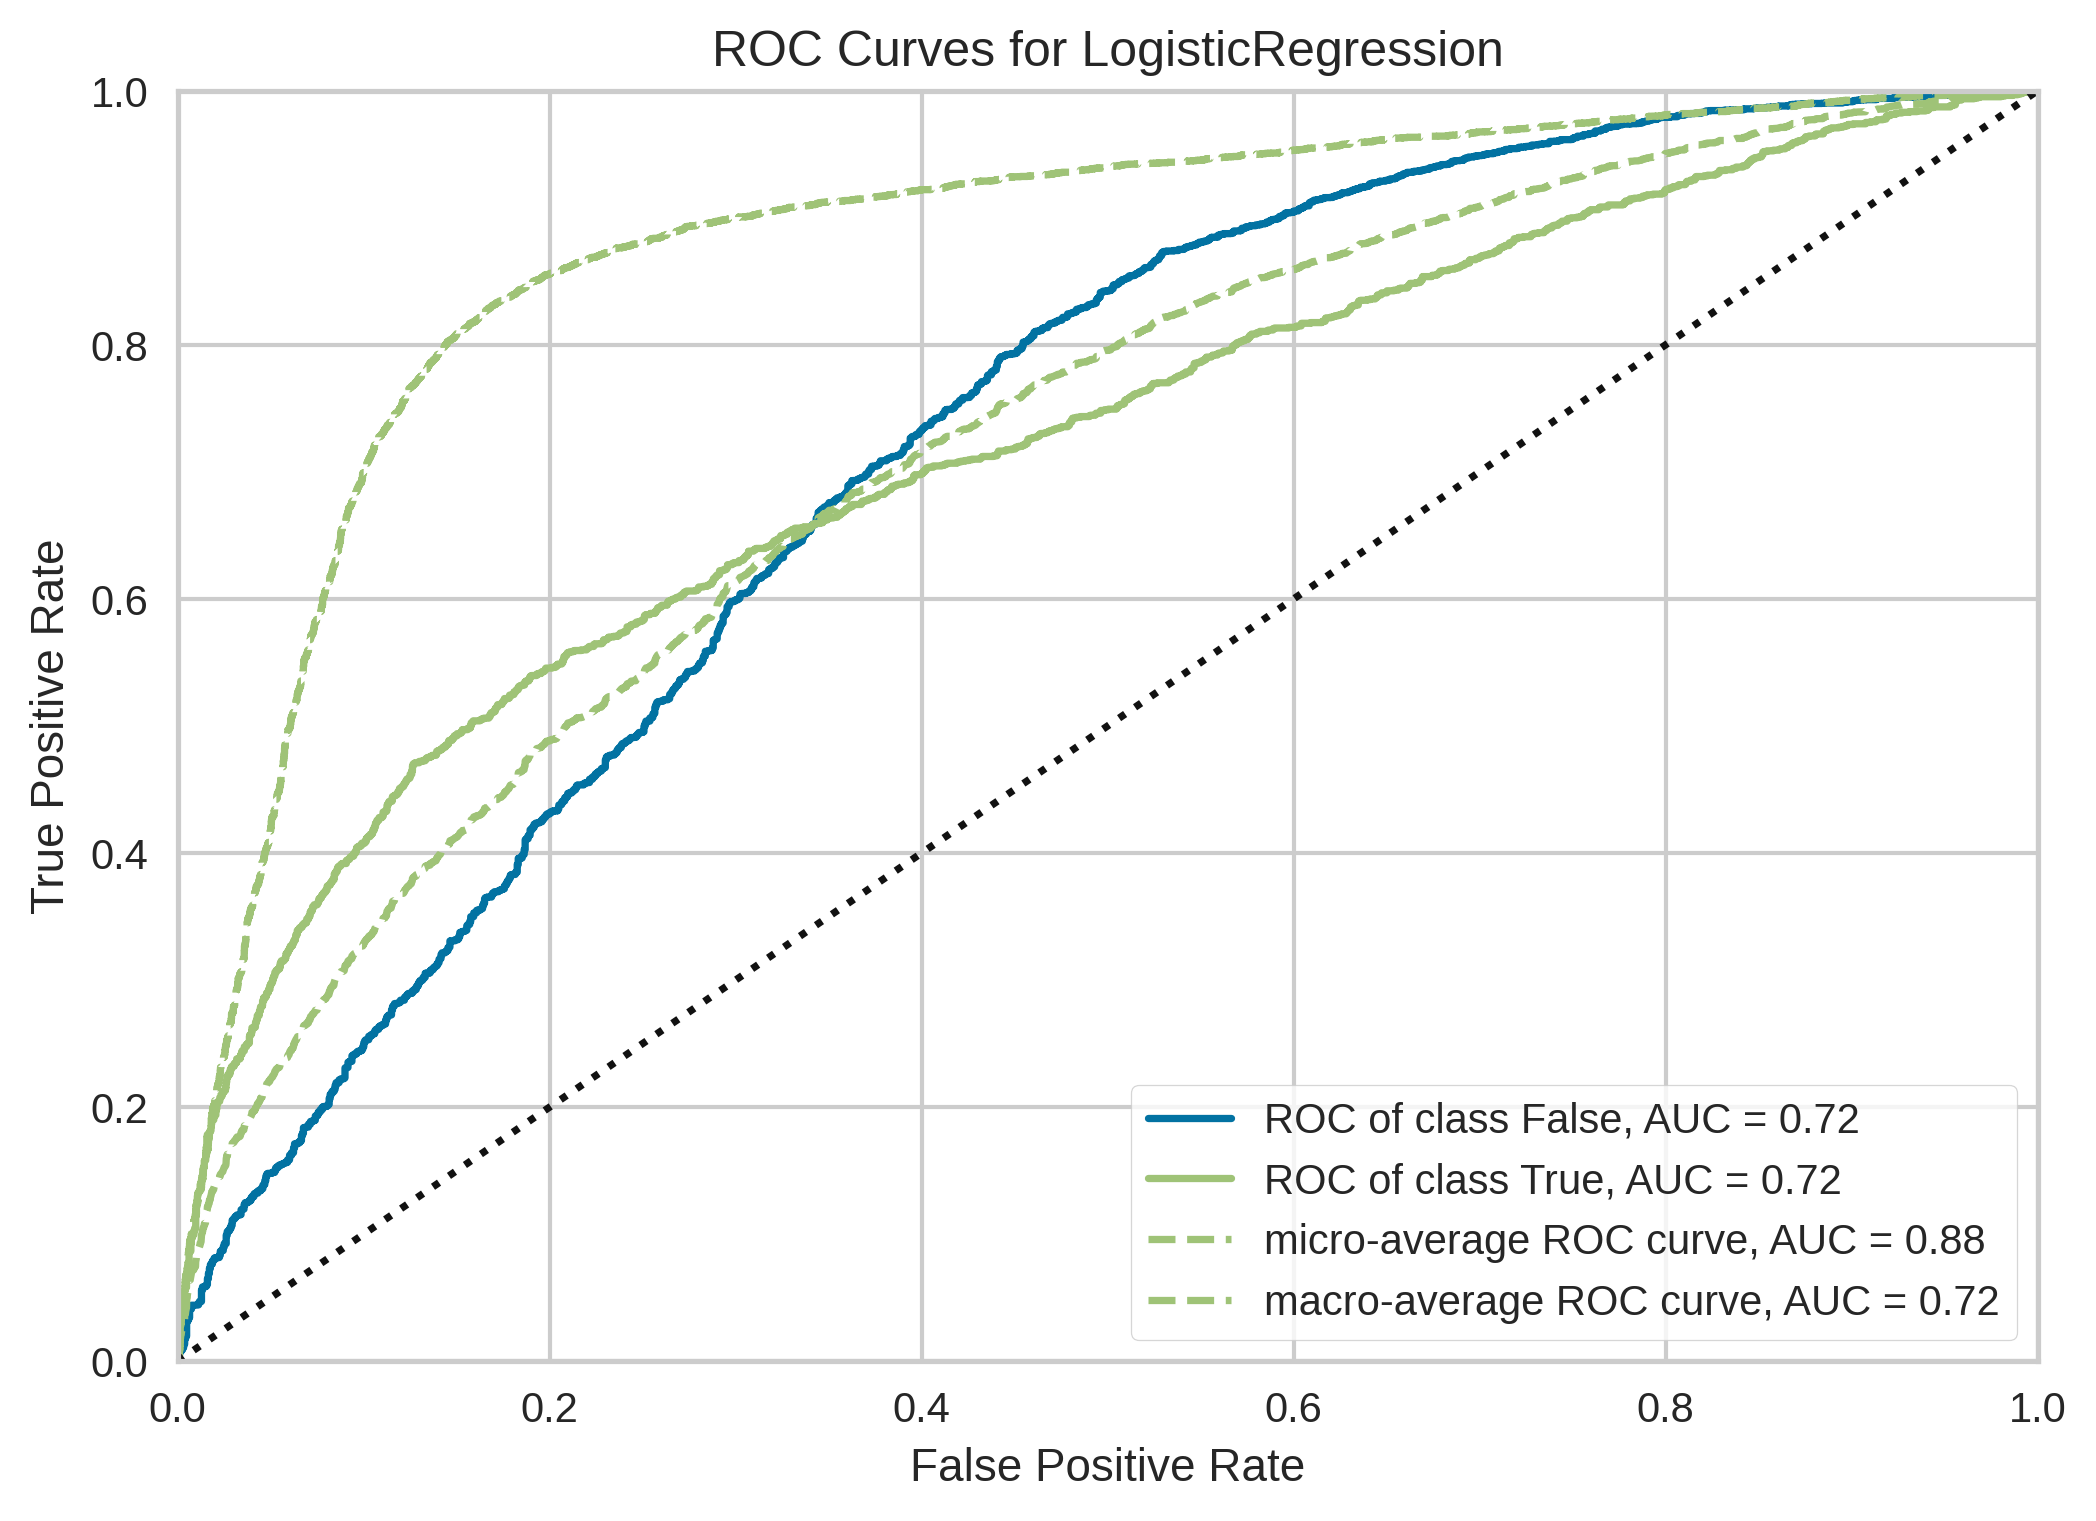

In [73]:
lr = create_model('lr')
plot_model(lr, plot = 'auc', scale = 3)

# **Building the Baseline Model with Text Feature Engineering** 


In [100]:
corpus = data_train['abstract'].fillna('')

In [101]:
vect_abs = TfidfVectorizer(max_features=50, stop_words='english')
tfidf_matrix = vect_abs.fit_transform(corpus)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f"abs_tfidf_{w}" for w in vect_abs.get_feature_names_out()])

In [103]:
datamodel_train_tfidf = pd.concat([datamodel_train.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)
print(datamodel_train_tfidf.shape)
datamodel_train_tfidf.head(1)

(31569, 55)


,Number of Authors,Abstract Length,institutions,field,high_impact_paper,abs_tfidf_algorithm,abs_tfidf_algorithms,abs_tfidf_analysis,abs_tfidf_applications,abs_tfidf_approach,...,abs_tfidf_real,abs_tfidf_results,abs_tfidf_state,abs_tfidf_study,abs_tfidf_systems,abs_tfidf_time,abs_tfidf_training,abs_tfidf_used,abs_tfidf_using,abs_tfidf_work
0,3,1133,National University of Singapore,Computer Science,True,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.138992,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
clf2 = ClassificationExperiment()
clf2 = setup(data = datamodel_train_tfidf, target = 'high_impact_paper',categorical_features=['institutions','field'],
             session_id = 123)
best = compare_models(include = ['lr', 'dt','xgboost'])

,Description,Value
0,Session id,123
1,Target,high_impact_paper
2,Target type,Binary
3,Original data shape,"(31569, 55)"
4,Transformed data shape,"(31569, 78)"
5,Transformed train set shape,"(22098, 78)"
6,Transformed test set shape,"(9471, 78)"
7,Numeric features,52
8,Categorical features,2
9,Rows with missing values,0.1%


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9325,0.9590,0.6799,0.9414,0.7894,0.7505,0.7647,0.5510
dt,Decision Tree Classifier,0.9051,0.8507,0.7422,0.7473,0.7445,0.6863,0.6865,0.3720
lr,Logistic Regression,0.8404,0.7512,0.2649,0.6851,0.3816,0.3101,0.3567,1.8580


# **Building the Baseline Model with SciBERT** 


In [111]:
import torch
from transformers import AutoTokenizer, AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model_name = 'allenai/scibert_scivocab_cased'  # ใช้แบบ cased
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

abstracts = data_train['abstract'].fillna('').tolist()

embeddings = []
batch_size = 8  # ปรับตาม GPU
for i in range(0, len(abstracts), batch_size):
    batch = abstracts[i:i+batch_size]
    inputs = tokenizer(batch, padding=True, truncation=True, return_tensors='pt', max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # CLS token
    embeddings.append(batch_embeddings)

embeddings = np.concatenate(embeddings, axis=0)
emb_df = pd.DataFrame(embeddings, columns=[f"scibert_{i}" for i in range(embeddings.shape[1])])

# ------------------------------
# 4️⃣ รวม features ทั้งหมด
# ------------------------------
feature_df = pd.concat([
    data_train[['Number of Authors', 'Abstract Length', 'institutions', 'field', 'high_impact_paper']].reset_index(drop=True),
    emb_df.reset_index(drop=True)], axis=1)


Device: cuda


In [115]:
clf2 = ClassificationExperiment()
clf2 = setup(data = feature_df, target = 'high_impact_paper',categorical_features=['institutions','field'],
             session_id = 123)
best = compare_models(include = ['lr', 'dt','xgboost'])

,Description,Value
0,Session id,123
1,Target,high_impact_paper
2,Target type,Binary
3,Original data shape,"(31569, 773)"
4,Transformed data shape,"(31569, 796)"
5,Transformed train set shape,"(22098, 796)"
6,Transformed test set shape,"(9471, 796)"
7,Numeric features,770
8,Categorical features,2
9,Rows with missing values,0.1%


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9776,0.9861,0.9047,0.9731,0.9376,0.9240,0.9249,13.1500
dt,Decision Tree Classifier,0.9156,0.8730,0.7898,0.7646,0.7769,0.7249,0.7251,33.3160
lr,Logistic Regression,0.8715,0.8378,0.4537,0.7608,0.5676,0.4979,0.5213,12.8050
